In [33]:
!pip install mosek 

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this project's internal filesystem.
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.
# See next cell for details.

import sys
print(sys.version)
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"
import re
import glob
import datetime as dt

import numpy as np
np.set_printoptions(precision=5, linewidth=120, suppress=True)
import pandas as pd
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [ ]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
alphaToken = None
 
if alphaToken is not None:
    import requests
    import time
    
    list_tickers = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
    
    for ticker in list_tickers:
        url = rf"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={alphaToken}&outputsize=full&datatype=csv"
        result = requests.get(url, allow_redirects=True)
        fname = f"daily_adjusted_{ticker}.csv"
        folder = "stock_data"
        if not os.path.isdir(folder):
            os.mkdir(folder)
        open(os.path.join(folder, fname), "wb").write(result.content)
        print(f"Downloaded {fname}.")
        # Limit is 5 downloads per minute.
        time.sleep(12)   

In [34]:
class DataReader:
    def __init__(self, folder_path, exclude=None):
        self.folder_path = folder_path
        self.name_format = r"daily_adjusted_*.csv"
        self.exclude = exclude if exclude is not None else []
        self.df_prices = None

    def read_data(self):
        # Get list of files from path, named as name_format 
        list_files = glob.glob(os.path.join(self.folder_path, self.name_format))
        file_names = "\n".join(list_files)
        print("Found data files: \n{}\n".format(file_names))

        # Exclude specified files
        for symbol in self.exclude:
            list_files.remove(os.path.join(self.folder_path, self.name_format.replace("*", symbol)))
    
        # Collect data from the files into a Dataframe
        dict_prices = {}
        for file_name in list_files: 
            m = re.search(self.name_format.replace("*", "(.+)"), file_name)
            
            # Get symbol name
            symbol = m.group(1)
        
            # Read data file
            df_data = pd.read_csv(file_name)

            # Set timestamp as index 
            df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])
            df_data = df_data.set_index('timestamp')
            df_data.index.name = "date"

            # Obtain adjusted close price data 
            dict_prices[symbol] = df_data['adjusted_close']

        self.df_prices = pd.concat(dict_prices.values(), axis=1, keys=dict_prices.keys()).sort_index()
        
    def get_period(self, start_date, end_date):              
        start_idx = self.df_prices.index.get_loc(pd.to_datetime(start_date), method='nearest')
        end_idx = self.df_prices.index.get_loc(pd.to_datetime(end_date), method='nearest')
        df_prices = self.df_prices.iloc[start_idx:(end_idx + 1)]
        
        return df_prices

In [35]:
# We load daily stock price data from CSV files. The data is adjusted for splits and dividends. 
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", exclude=["SPY"])
dr.read_data()
df_prices = dr.get_period(start_date="2016-03-18", end_date="2021-03-18")
columns = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
df_prices = df_prices[columns]

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv



In [36]:
# Convert daily prices to weekly prices
df_weekly_prices = df_prices.resample('W').last()

In [37]:
# Compute weekly logarithmic returns
df_weekly_log_returns = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
df_weekly_log_returns = df_weekly_log_returns.dropna(how='all')
df_weekly_log_returns = df_weekly_log_returns.fillna(0)

array([[<AxesSubplot:title={'center':'PM'}>, <AxesSubplot:title={'center':'LMT'}>,
        <AxesSubplot:title={'center':'MCD'}>],
       [<AxesSubplot:title={'center':'MMM'}>, <AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'MSFT'}>],
       [<AxesSubplot:title={'center':'TXN'}>, <AxesSubplot:title={'center':'CSCO'}>, <AxesSubplot:>]], dtype=object)

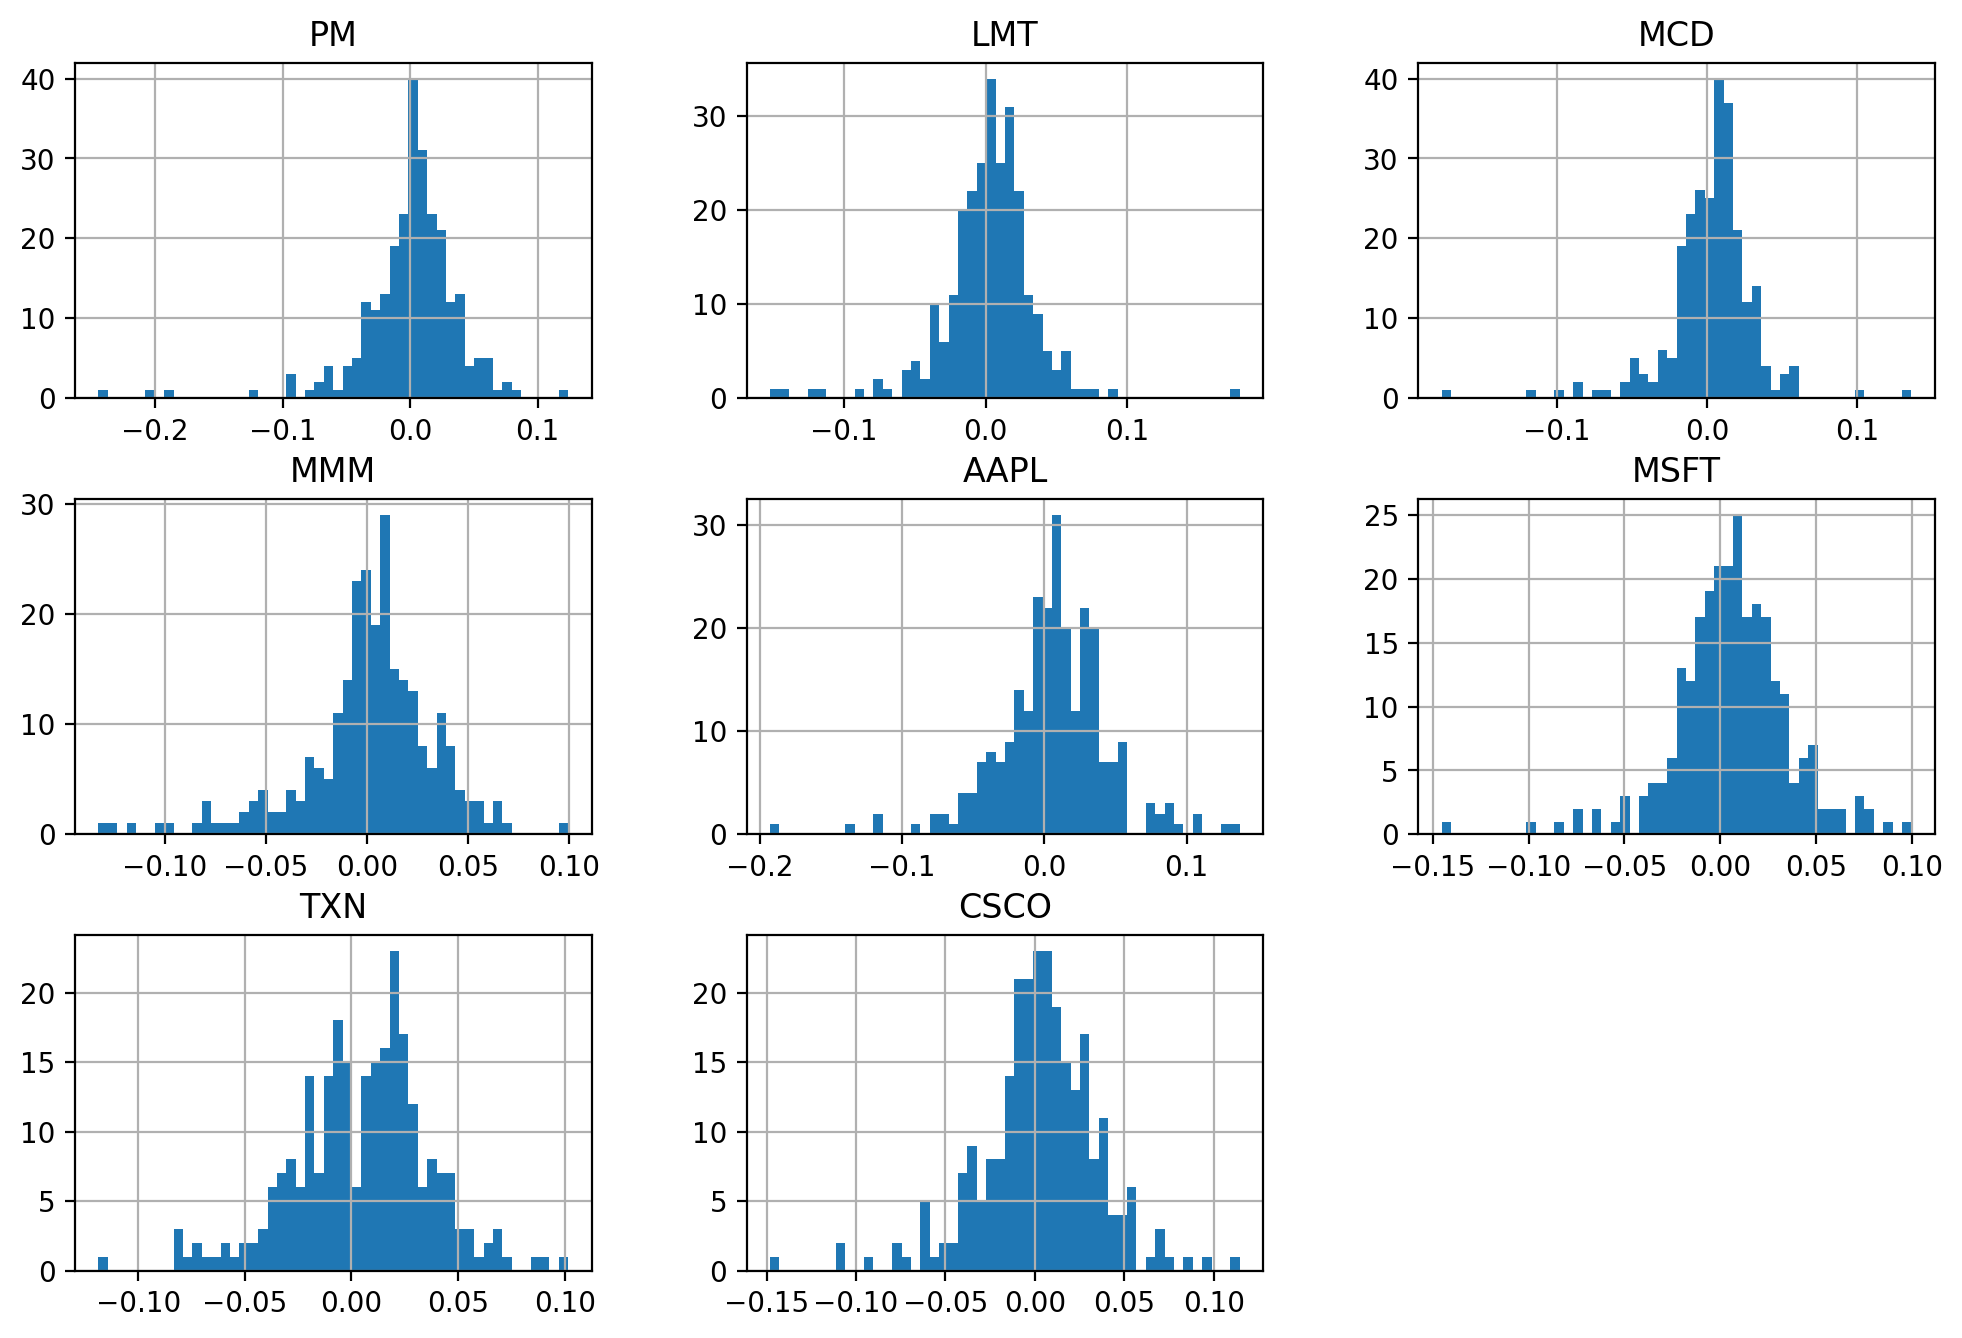

In [38]:
# Show histograms of weekly logarithmic returns
df_weekly_log_returns.hist(bins=50)

In [39]:
# Compute mean and covariance of weekly logarithmic returns
return_array = df_weekly_log_returns.to_numpy()
T = return_array.shape[0]
m_weekly_log = np.mean(return_array, axis=0)
S_weekly_log = np.cov(return_array.transpose())

In [40]:
# Convert weekly logarithmic return statistics to yearly linear return statistics
def get_lin_parameters(m_weekly_log, S_weekly_log):              
    # Project logarithmic return statistics to investment horizon
    m_log = 52 * m_weekly_log
    S_log = 52 * S_weekly_log
    
    # Pricing
    p_0 = df_weekly_prices.iloc[0].to_numpy()
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)
    
    # Linear return statistics on the investment horizon
    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P

    return m, S

In [41]:
def EfficientFrontier(N, m, G, deltas, vp, vm, fp, fm, up, um, lp, lm, pcoef):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Real variables 
        # The variable x is the fraction of holdings in each security.    
        x = M.variable("x", N, Domain.unbounded())
        xp = M.variable("xp", N, Domain.greaterThan(0.0))
        xm = M.variable("xm", N, Domain.greaterThan(0.0))
        
        # Binary variables
        yp = M.variable("yp", N, Domain.binary())
        ym = M.variable("ym", N, Domain.binary()) 
        
        # Constraint assigning xp and xm to be the positive and negative part of x.
        M.constraint('pos-neg-part', Expr.sub(x, Expr.sub(xp, xm)), Domain.equalsTo(0.0))
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
        
        # Auxiliary variable for 130/30 leverage constraint 
        z = M.variable("z", N, Domain.unbounded())

        # Bound constraints
        M.constraint('ubound-p', Expr.sub(Expr.mul(up, yp), xp), Domain.greaterThan(0.0))
        M.constraint('ubound-m', Expr.sub(Expr.mul(um, ym), xm), Domain.greaterThan(0.0))
        M.constraint('lbound-p', Expr.sub(xp, Expr.mul(lp, yp)), Domain.greaterThan(0.0))
        M.constraint('lbound-m', Expr.sub(xm, Expr.mul(lm, ym)), Domain.greaterThan(0.0))
        
        # Exclusive buy-sell constraint
        M.constraint('exclusion', Expr.add(yp, ym), Domain.lessThan(1.0))
        
        # Budget constraint with transaction cost terms
        fixcost_terms = Expr.add([Expr.dot(fp, yp), Expr.dot(fm, ym)])
        varcost_terms = Expr.add([Expr.dot(vp, xp), Expr.dot(vm, xm)])
        budget_terms = Expr.add([Expr.sum(x), varcost_terms, fixcost_terms])
        M.constraint('budget', budget_terms, Domain.equalsTo(1.0))

        # 130/30 leverage constraint
        M.constraint('leverage-gt', Expr.sub(z, x), Domain.greaterThan(0.0))
        M.constraint('leverage-ls', Expr.add(z, x), Domain.greaterThan(0.0))
        M.constraint('leverage-sum', Expr.add([Expr.sum(z), varcost_terms, fixcost_terms]), Domain.equalsTo(1.6))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        penalty = Expr.mul(pcoef, Expr.sum(Expr.add(xp, xm)))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.sub(Expr.dot(m, x), penalty), Expr.mul(delta, s)))
        
        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, Expr.mul(G.transpose(), x)), Domain.inRotatedQCone())
    
        columns = ["delta", "obj", "return", "risk", "x_sum", "tcost"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for idx, d in enumerate(deltas):
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = np.sqrt(2 * s.level()[0])            
            tcost = np.dot(vp, xp.level()) + np.dot(vm, xm.level()) + np.dot(fp, yp.level()) + np.dot(fm, ym.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, 
                             sum(x.level()), tcost] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)

        return df_result

In [42]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, S = get_lin_parameters(m_weekly_log, S_weekly_log)

# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(S)

,delta,obj,return,risk,x_sum,tcost,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,-1.708617,0.166289,0.192020,0.944059,0.055941,0.102567,1.020206e-01,2.813243e-01,1.428231e-01,-0.050000,0.117411,7.735556e-02,1.705586e-01
1,73.861998,-1.226078,0.171358,0.192330,0.944059,0.055941,0.096797,1.013099e-01,2.804641e-01,1.337253e-01,-0.050000,0.130049,8.386679e-02,1.678473e-01
2,54.555948,-0.868106,0.178220,0.192898,0.944059,0.055941,0.088985,1.003490e-01,2.792978e-01,1.214114e-01,-0.050000,0.147161,9.268031e-02,1.641750e-01
3,40.296113,-0.601590,0.187511,0.193934,0.944059,0.055941,0.078415,9.904915e-02,2.777170e-01,1.047347e-01,-0.050000,0.170325,1.046183e-01,1.592007e-01
4,29.763514,-0.401878,0.200089,0.195820,0.944059,0.055941,0.064095,9.728721e-02,2.755796e-01,8.216403e-02,-0.050000,0.201690,1.207748e-01,1.524682e-01
5,21.983926,-0.250518,0.216543,0.199102,0.944059,0.055941,0.050000,9.386186e-02,2.710674e-01,5.040570e-02,-0.050000,0.243423,1.427399e-01,1.425619e-01
6,16.237767,-0.132739,0.252287,0.208724,0.944059,0.055941,-0.050000,1.035256e-01,2.776372e-01,5.000000e-02,0.050000,0.251403,1.330985e-01,1.283950e-01
7,11.993539,-0.036735,0.282416,0.218012,0.937624,0.062376,-0.050000,9.827744e-02,2.706249e-01,-5.000001e-02,0.050000,0.322972,1.819534e-01,1.137964e-01
8,8.858668,0.041378,0.310494,0.230332,0.937624,0.062376,-0.050000,6.573022e-02,2.199476e-01,-4.999963e-02,0.062263,0.416607,2.119056e-01,6.116990e-02
9,6.543189,0.107272,0.350117,0.251882,0.942070,0.057930,-0.066968,4.999996e-02,1.427712e-01,-5.000001e-02,0.095948,0.528814,2.415049e-01,0.000000e+00


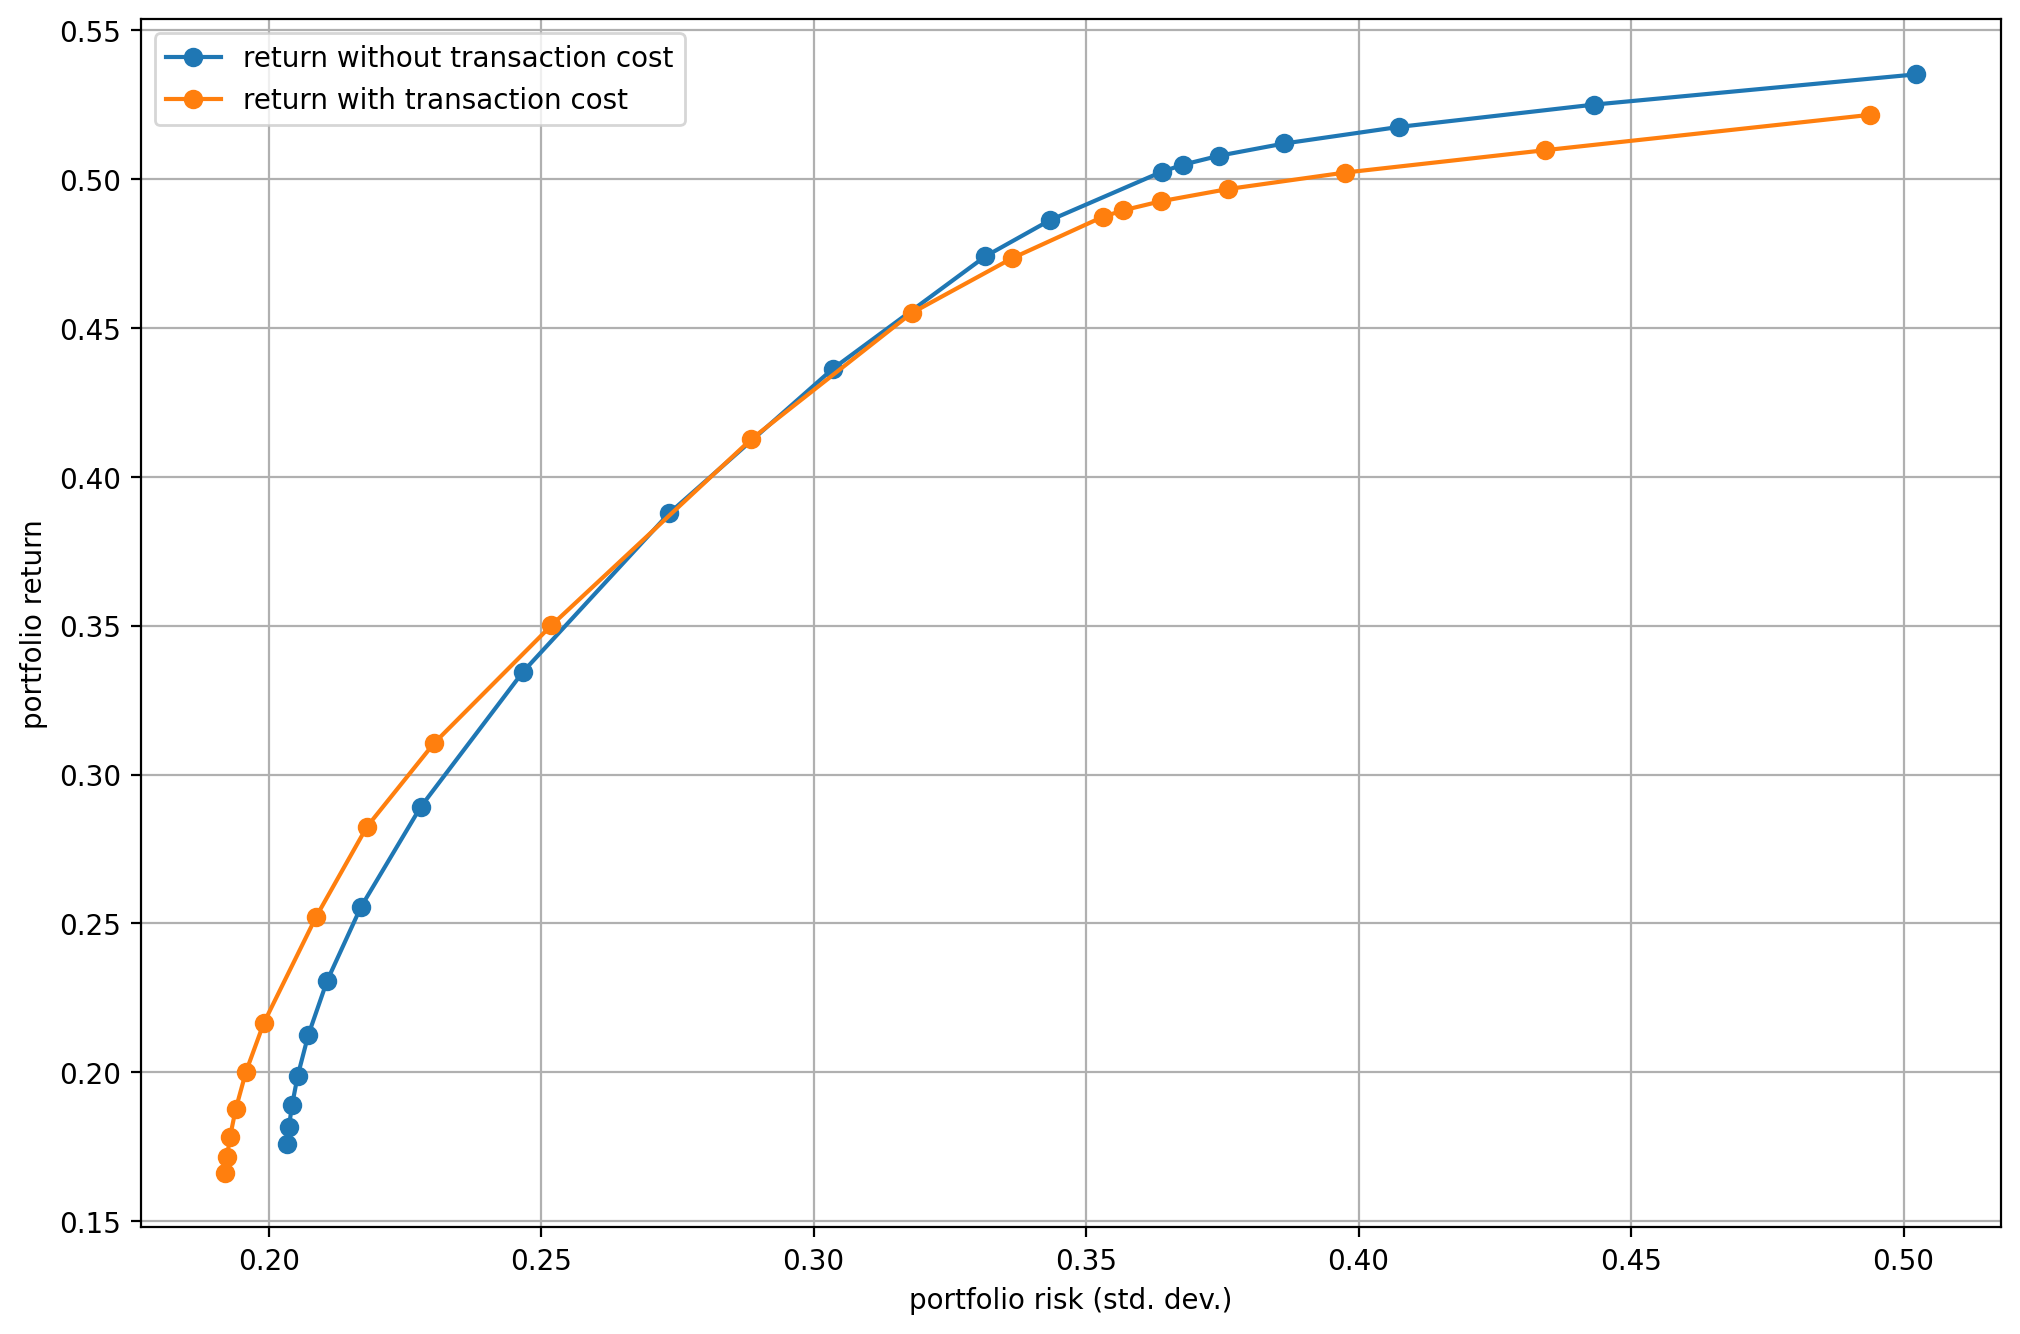

In [43]:
deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]
ax = plt.gca()
for a in [0, 1]:
    pcoef = a * 0.03
    fp = a * 0.005 * np.ones(N) # Depends on portfolio value
    fm = a * 0.01 * np.ones(N) # Depends on portfolio value
    vp = a * 0.01 * np.ones(N)
    vm = a * 0.02 * np.ones(N)
    up = 2.0
    um = 2.0
    lp = a * 0.05
    lm = a * 0.05

    df_result = EfficientFrontier(N, m, G, deltas, vp, vm, fp, fm, up, um, lp, lm, pcoef)
    df_result.plot(ax=ax, x="risk", y="return", style="-o", 
                   xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return without transaction cost", "return with transaction cost"]);
df_result